# Mahalanobis distance based anomaly detection on Multivariate data

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

import random
import logging
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [9, 2]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["agg.path.chunksize"] = 100000
pd.set_option("plotting.backend", "matplotlib")
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

logging.basicConfig(level=logging.INFO)

time: 1.63 s (started: 2023-07-25 16:34:50 -04:00)


In [2]:
from sklearn.preprocessing import MinMaxScaler
from numalogic.models.autoencoder import AutoencoderTrainer
from numalogic.models.autoencoder.variants import SparseVanillaAE
from smd.datamodule import SMDDataModule

SEQ_LEN = 12
MAX_EPOCHS = 50
N_FEATURES = 38

datamodule = SMDDataModule(
    data_dir="data/",
    seq_len=SEQ_LEN,
    preproc_transforms=[MinMaxScaler()],
)
model = SparseVanillaAE(seq_len=SEQ_LEN, n_features=N_FEATURES, encoder_layersizes=(8, 16, 32), decoder_layersizes=(32, 16, 8))
trainer = AutoencoderTrainer(
    accelerator="cpu",
    max_epochs=MAX_EPOCHS,
    enable_model_summary=True,
    enable_progress_bar=True
)
trainer.fit(model, datamodule=datamodule)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/gn/5h0k08f904z3t0g0v28wq3rw0000gq/T/tmp8rhrjq1_
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/gn/5h0k08f904z3t0g0v28wq3rw0000gq/T/tmp8rhrjq1_/_remote_module_non_scriptable.py
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | encoder | _Encoder | 1.0 K 
1 | decoder | _Decoder | 924   
-------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
INFO:numalogic.tools.callbacks:validation_lo

Train size: (14240, 38)
Val size: (2848, 38)


INFO:numalogic.tools.callbacks:epoch=0, training_loss=0.17561
INFO:numalogic.tools.callbacks:validation_loss=0.01754
INFO:numalogic.tools.callbacks:epoch=5, training_loss=0.06182
INFO:numalogic.tools.callbacks:validation_loss=0.01636
INFO:numalogic.tools.callbacks:epoch=10, training_loss=0.05947
INFO:numalogic.tools.callbacks:validation_loss=0.01474
INFO:numalogic.tools.callbacks:epoch=15, training_loss=0.05755
INFO:numalogic.tools.callbacks:validation_loss=0.01318
INFO:numalogic.tools.callbacks:epoch=20, training_loss=0.04633
INFO:numalogic.tools.callbacks:validation_loss=0.01295
INFO:numalogic.tools.callbacks:epoch=25, training_loss=0.01794
INFO:numalogic.tools.callbacks:validation_loss=0.01279
INFO:numalogic.tools.callbacks:epoch=30, training_loss=0.01753
INFO:numalogic.tools.callbacks:validation_loss=0.01246
INFO:numalogic.tools.callbacks:epoch=35, training_loss=0.01729
INFO:numalogic.tools.callbacks:validation_loss=0.01196
INFO:numalogic.tools.callbacks:epoch=40, training_loss=0.0

time: 56.4 s (started: 2023-07-25 16:34:59 -04:00)


In [3]:
train_reconerr = trainer.predict(model, dataloaders=datamodule.train_dataloader(), unbatch=True).numpy()
val_reconerr = trainer.predict(model, dataloaders=datamodule.val_dataloader(), unbatch=True).numpy()
test_reconerr = trainer.predict(model, dataloaders=datamodule.predict_dataloader(), unbatch=True).numpy()

Test size: (8543, 38)
Test size: (8543, 38)
Test size: (8543, 38)
time: 728 ms (started: 2023-07-25 16:35:59 -04:00)


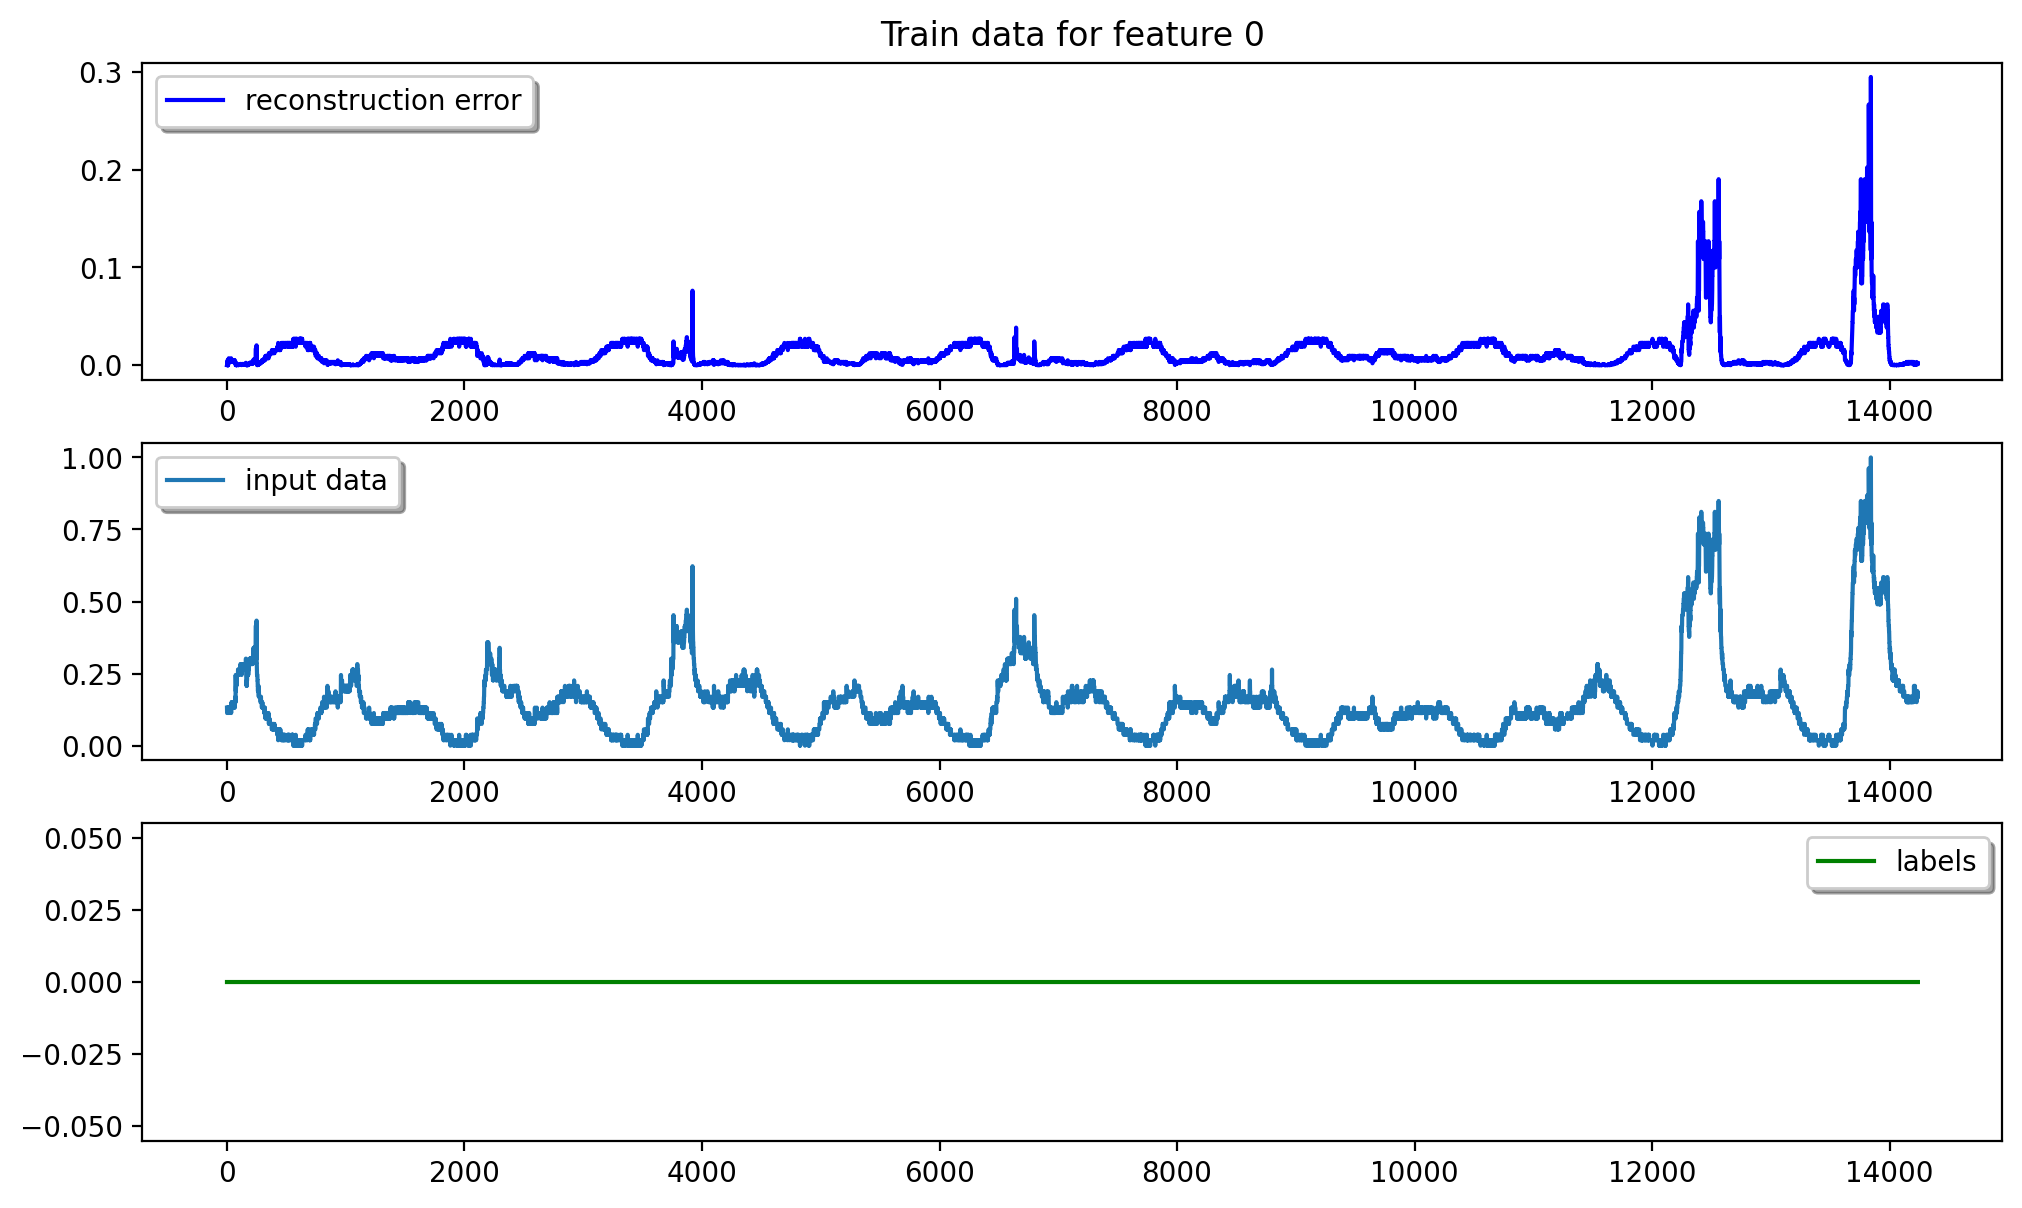

time: 354 ms (started: 2023-07-25 16:36:42 -04:00)


In [5]:
# def plot_reconerr_comparision(reconerr, input_, labels, feature_idx=0, start=0, end=None, title=None):
#     r"""Plots the reconstruction error with respect to the input and output labels."""
#     end = end or len(reconerr)
#     fig, ax = plt.subplots(3, 1, figsize=(12, 7))
#     ax[0].plot(reconerr[start:end, feature_idx], color="b", label="reconstruction error")
#     ax[0].legend(shadow=True)
#     ax[1].plot(input_[start:end, feature_idx], label="input data")
#     ax[1].legend(shadow=True)
#     ax[2].plot(labels[start:end], color="g", label="labels")
#     ax[2].legend(shadow=True)
#     if title:
#         ax[0].set_title(title)
#
#     return fig
from shared.plots import plot_reconerr_comparision

feature_idx = 0
_ = plot_reconerr_comparision(
    train_reconerr,
    datamodule.train_data,
    datamodule.train_labels,
    feature_idx=feature_idx,
    title=f"Train data for feature {feature_idx}"
)

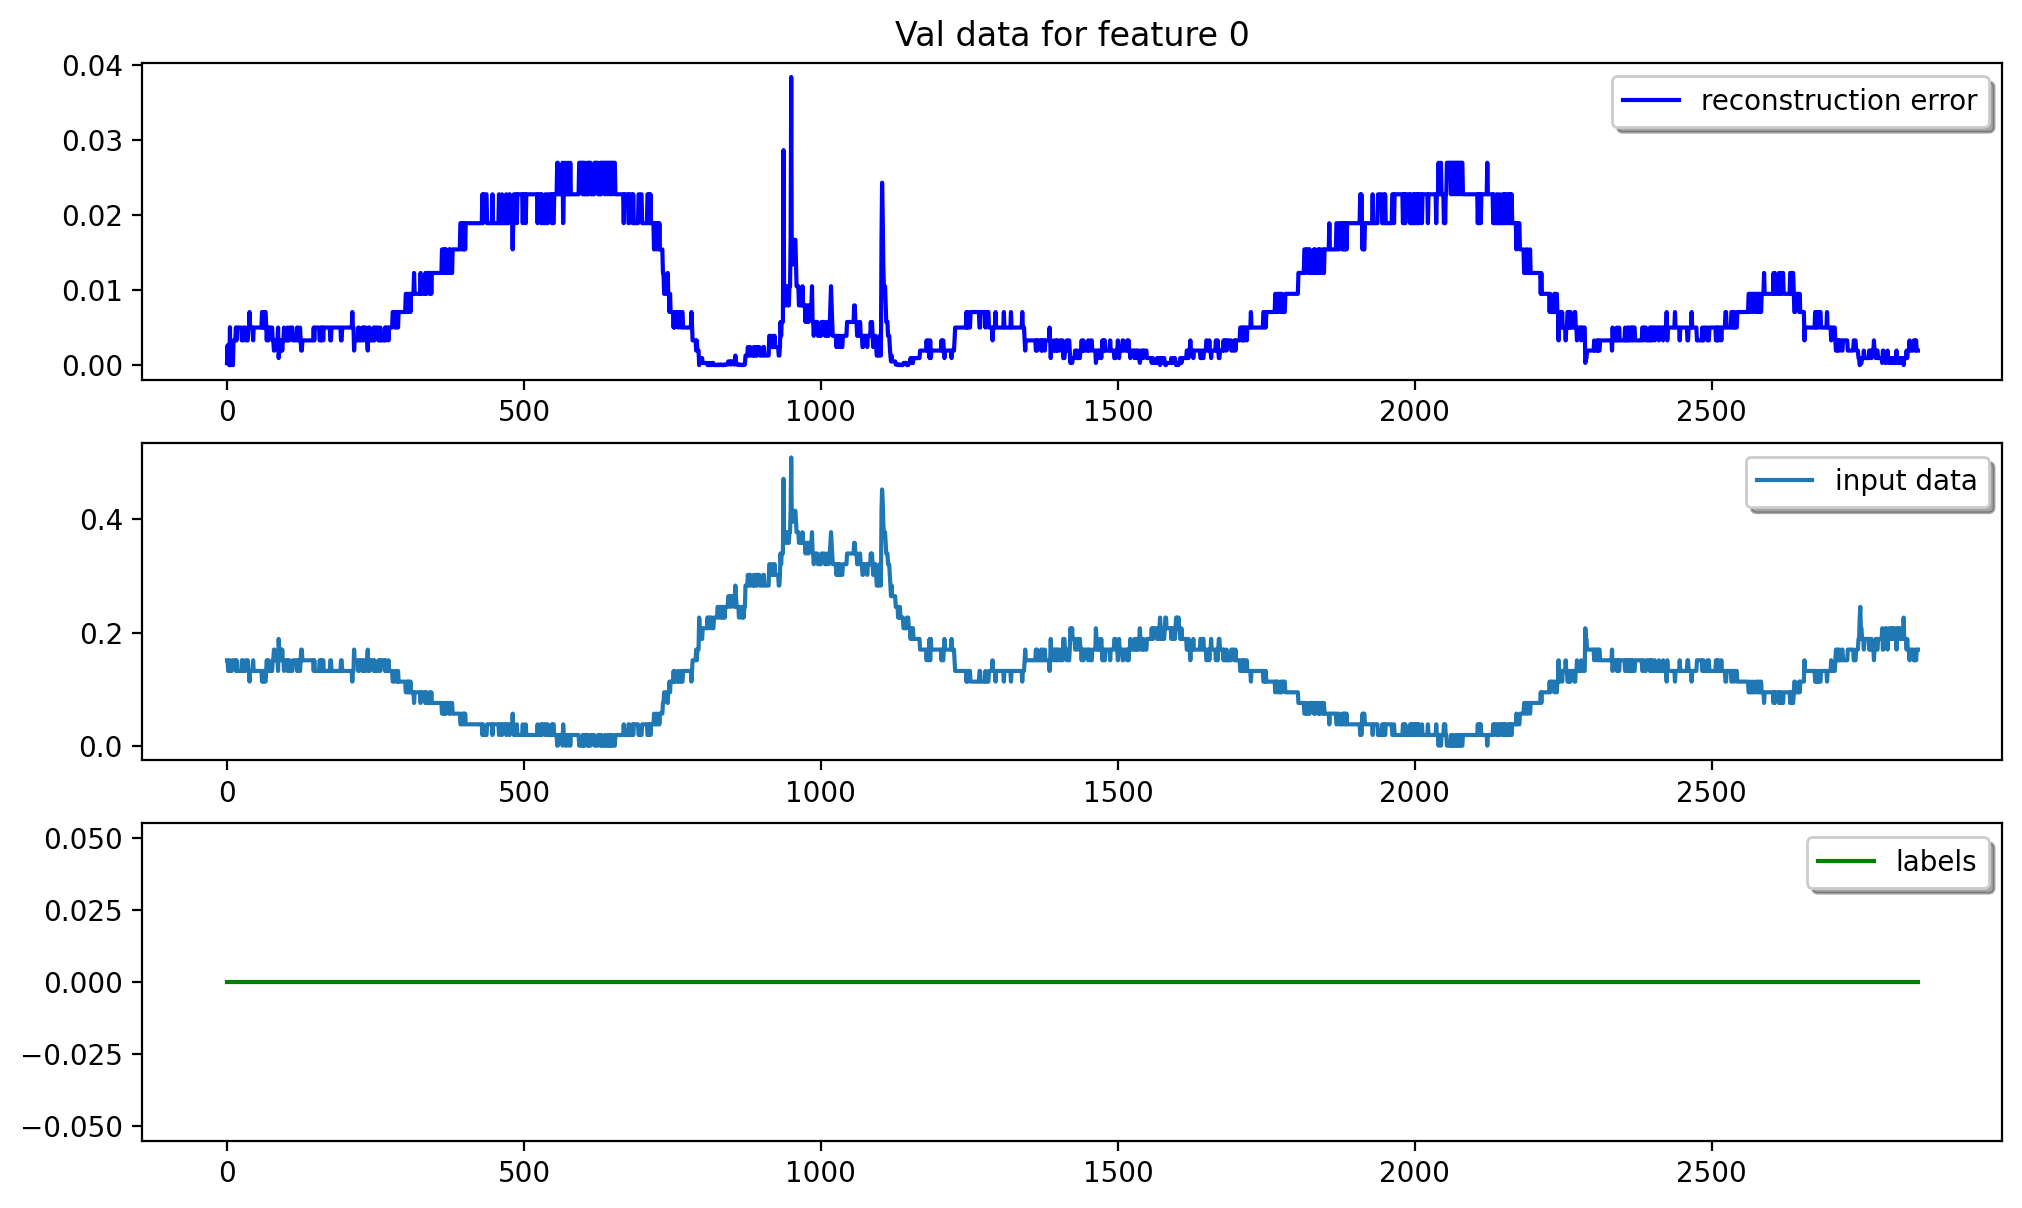

time: 300 ms (started: 2023-07-25 16:36:58 -04:00)


In [6]:
_ = plot_reconerr_comparision(
    val_reconerr,
    datamodule.val_data,
    datamodule.val_labels,
    feature_idx=feature_idx,
    title=f"Val data for feature {feature_idx}"
)

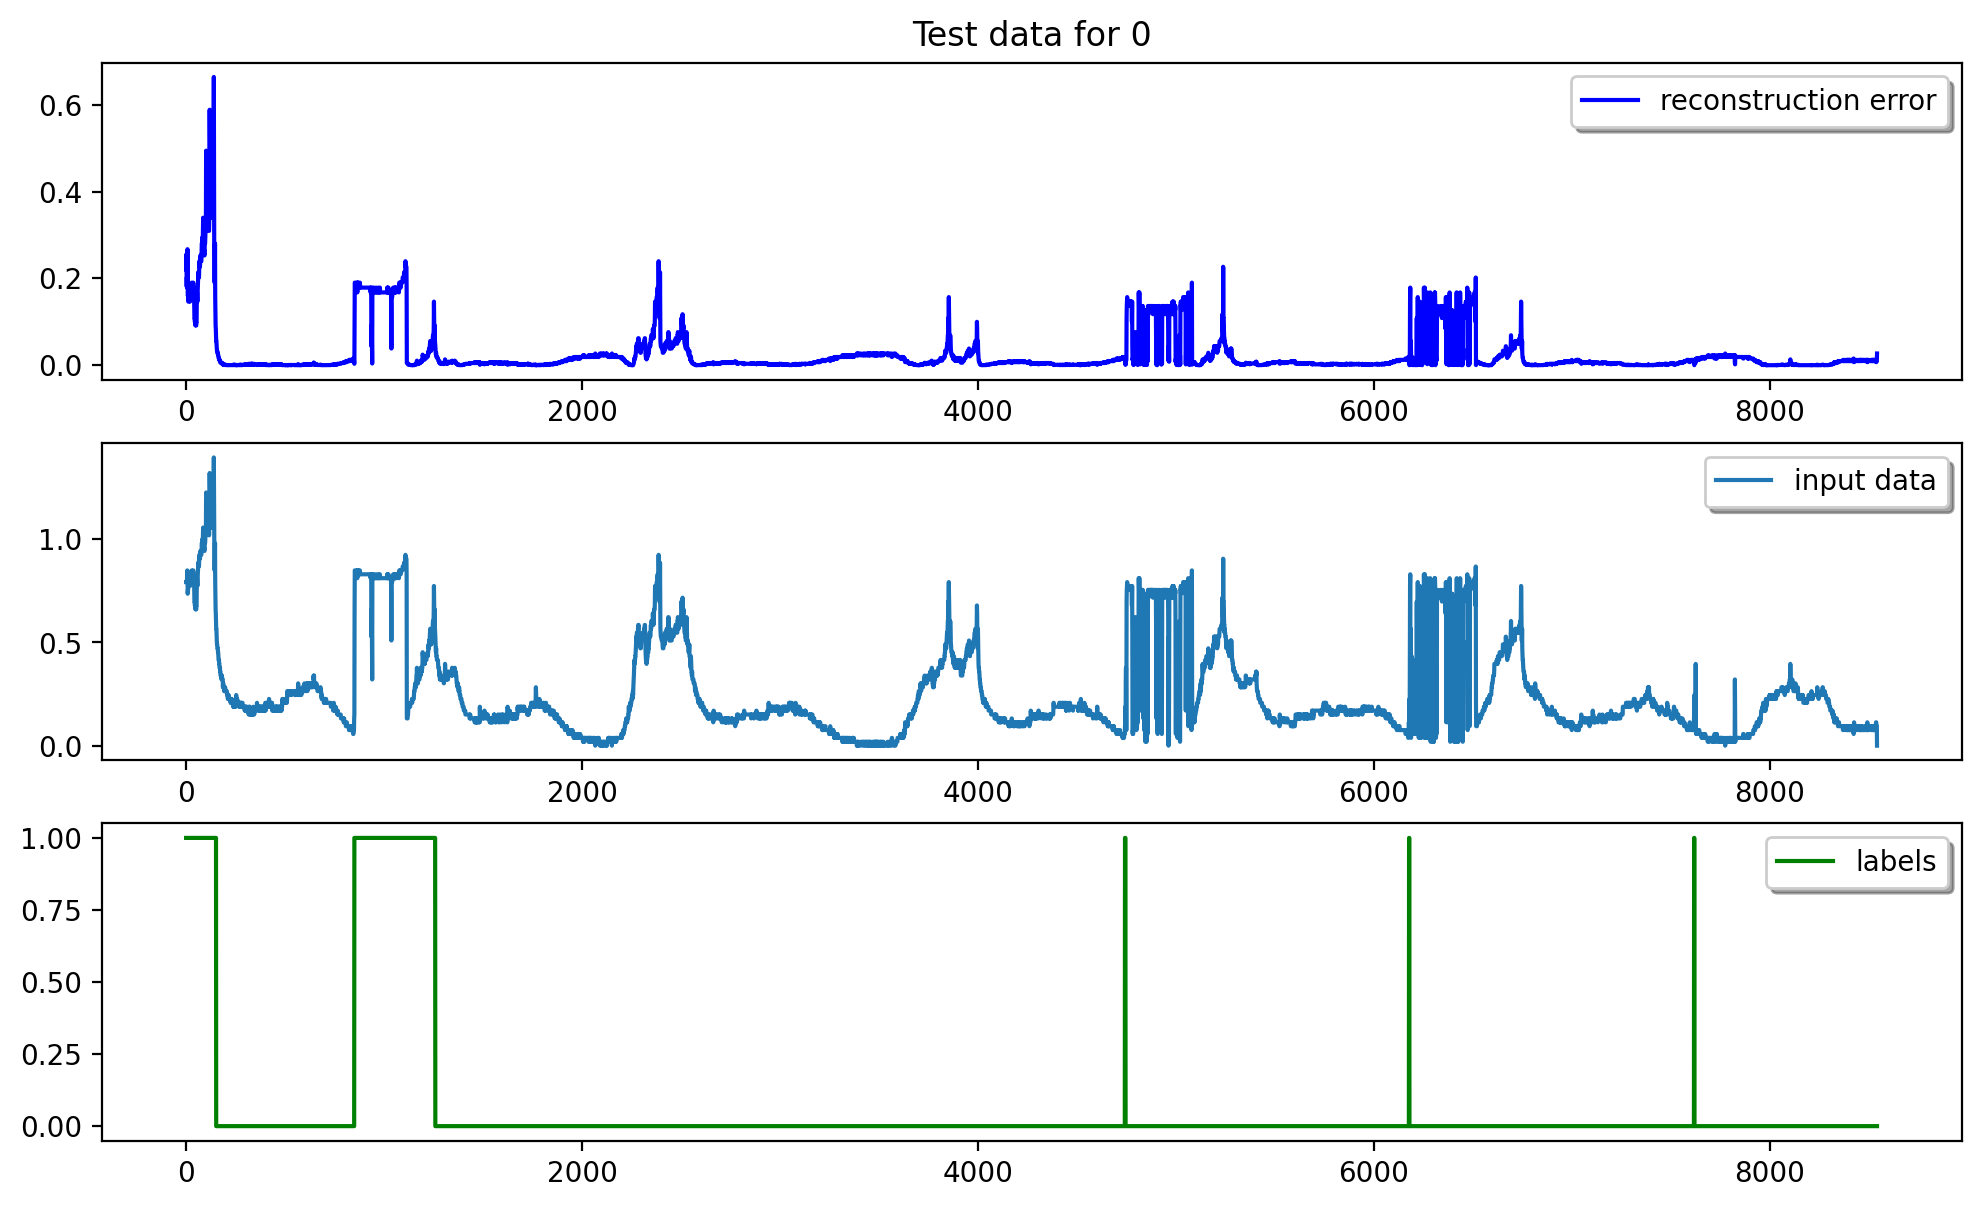

time: 398 ms (started: 2023-07-25 16:37:09 -04:00)


In [7]:
_ = plot_reconerr_comparision(
    test_reconerr,
    datamodule.test_data,
    datamodule.test_labels,
    feature_idx=feature_idx,
    title=f"Test data for {feature_idx}"
)

## Calculate the Mahalanobis distance on the validation reconstruction error

In [16]:
from smd.mahalanobis import MahalanobisThreshold

clf = MahalanobisThreshold()
clf.fit(val_reconerr)
print(clf.threshold, clf.std_factor)
md_test_scores = clf.score_samples(test_reconerr)

16.457174928013067 3.162277660168379
time: 148 ms (started: 2023-07-25 16:38:58 -04:00)


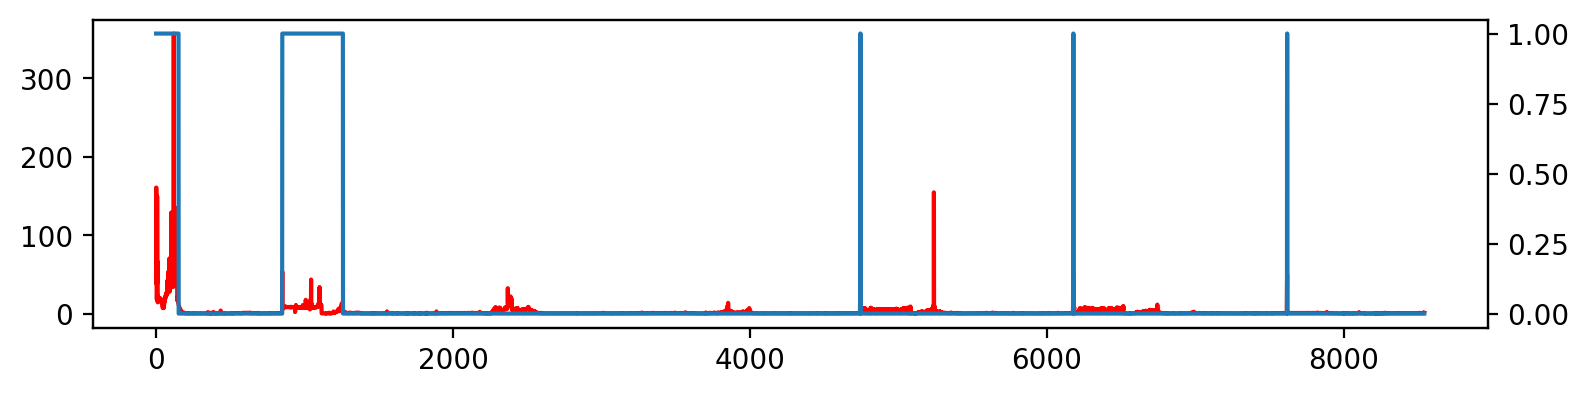

time: 105 ms (started: 2023-07-25 16:38:59 -04:00)


In [17]:
ax1 = plt.subplot()
ax1.plot(md_test_scores, color="r")
ax2 = ax1.twinx()
ax2.plot(datamodule.test_labels)

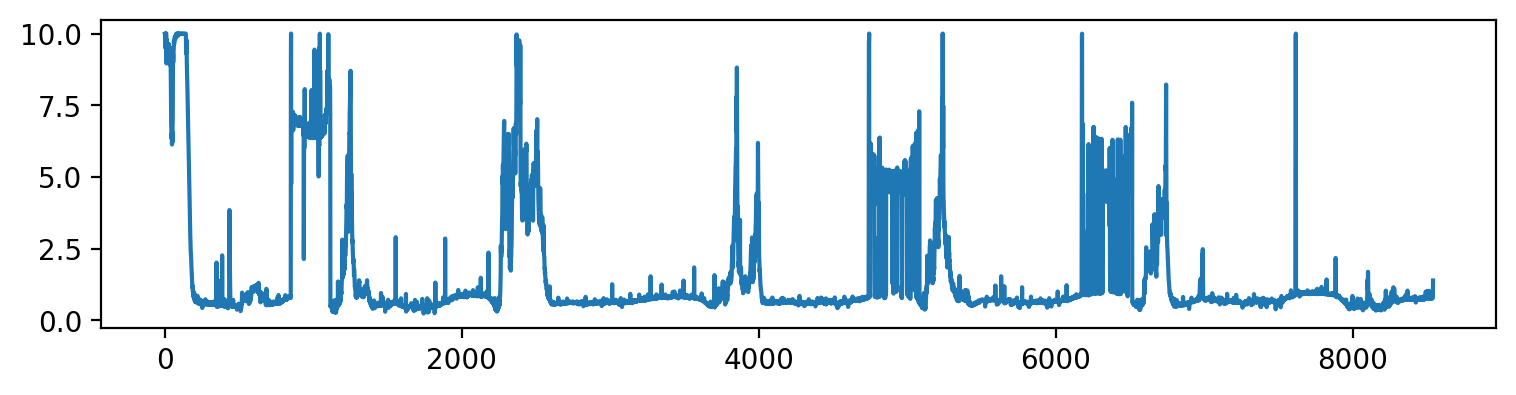

time: 108 ms (started: 2023-07-25 16:40:57 -04:00)


In [20]:
from numalogic.transforms import TanhNorm

tanh_norm = TanhNorm()
plt.plot(tanh_norm.transform(md_test_scores))

## Comparision with standard deviation threshold

In [21]:
from numalogic.models.threshold import StdDevThreshold

stddev_clf = StdDevThreshold()
stddev_clf.fit(val_reconerr)
test_scores = np.mean(stddev_clf.score_samples(test_reconerr), axis=1)

time: 1.31 ms (started: 2023-07-25 16:41:09 -04:00)


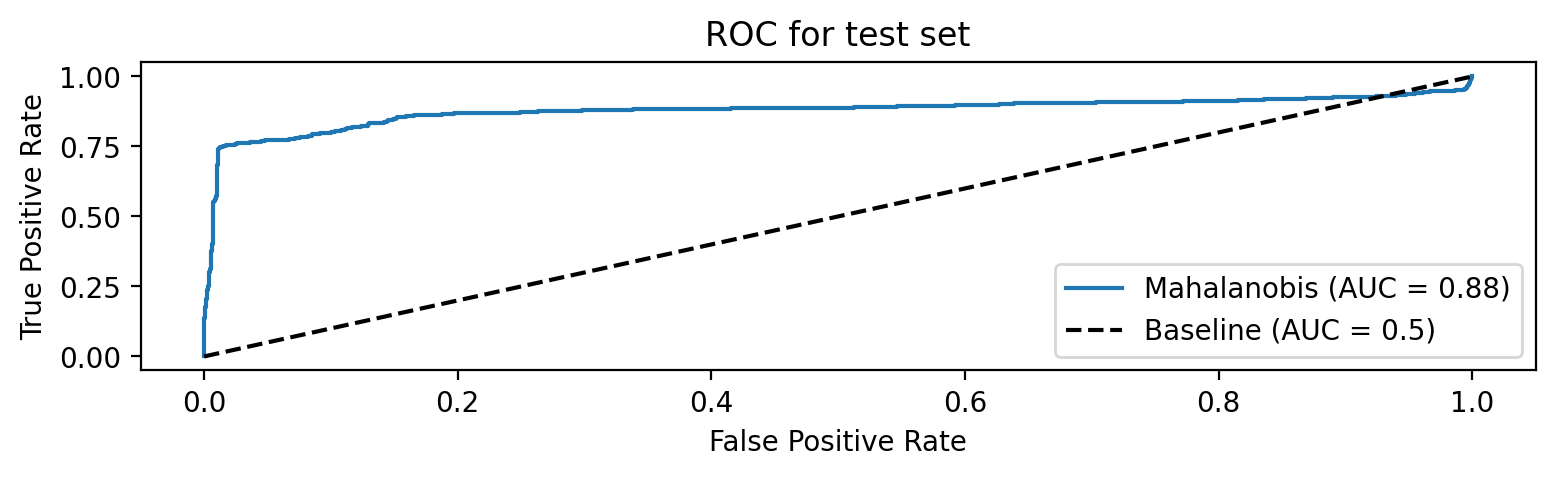

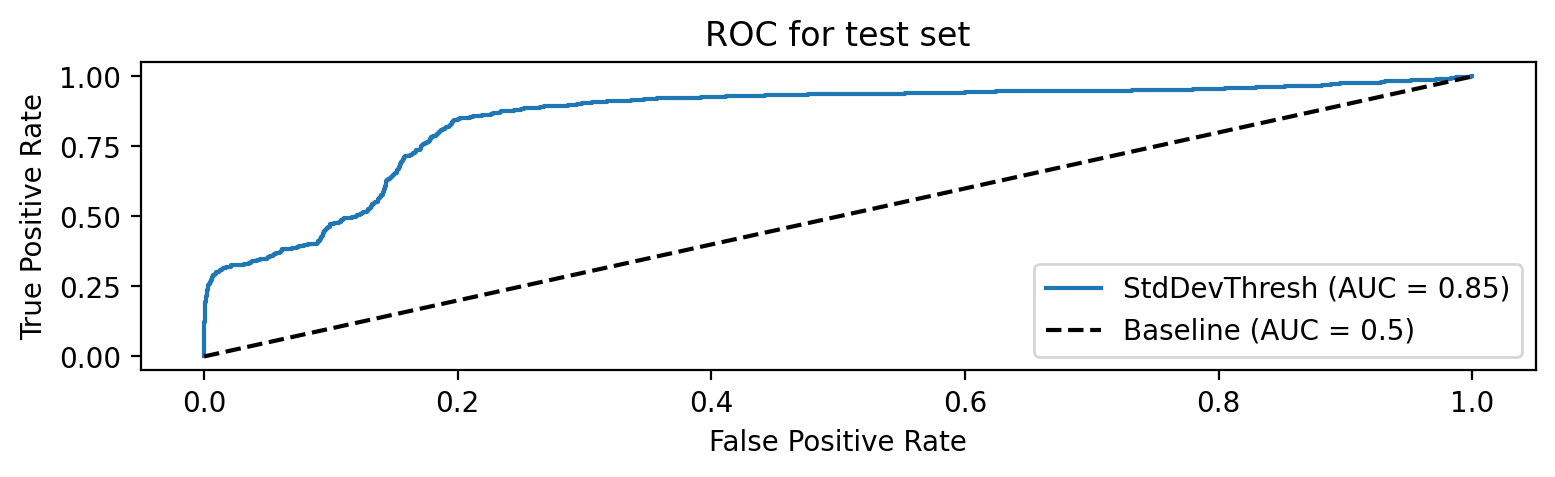

time: 238 ms (started: 2023-07-25 16:47:14 -04:00)


In [33]:
from shared.plots import plot_roc_curve

plot_roc_curve(datamodule.test_labels, md_test_scores, "Mahalanobis", title="ROC for test set")
plot_roc_curve(datamodule.test_labels, test_scores, "StdDevThresh", title="ROC for test set")